### Detect difficulty of English text and visualize it

In [1]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import sklearn.metrics
import matplotlib.pyplot as plt
import math

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import AutoModel, AutoTokenizer, BertTokenizer, BertModel

from models.attention import SimpleAttention
from models.attention2 import SimpleAttention2
from dataset.english_cefr_dataset import EnglishCEFRDataset
from util.metrics import ClassificationMetrics

LEARNING_RATE = 3e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 4
NUM_EPOCHS = 10
LOAD_FROM = None
DATA_ROOT = Path("training_data")
NUM_CLASS = 6
EXP_FOLDER = Path("exp1")

/home/cyrus/virtualenv/text/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Dataset and Model

In [2]:
dataset = EnglishCEFRDataset(DATA_ROOT / "cefr_leveled_texts.csv")
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.7, 0.1, 0.2])

# train_dataset = Subset(train_dataset, np.arange(500))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_dataset = Subset(val_dataset, np.arange(20))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
model = SimpleAttention2(NUM_CLASS, vocab_size=len(tokenizer)).to(DEVICE)
criterion = nn.CrossEntropyLoss(reduction="sum")  # to get average easily
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [3]:
for epoch in range(NUM_EPOCHS):
    print(f"Epoch [{epoch}/{NUM_EPOCHS}]")

    model.train()
    for batch_idx, (sentences, labels) in enumerate(train_loader):
        inputs = tokenizer(sentences, return_tensors="pt", padding=True).to(DEVICE)
        labels = torch.LongTensor(labels).to(DEVICE)

        outputs = model(**inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 500 == 0:
            print(f"[Batch {batch_idx:4d}/{len(train_loader)}] Loss: {loss.item()/BATCH_SIZE:.4f}")

    model.eval()
    val_loss = 0
    val_truths = []
    val_outputs = []
    for batch_idx, (sentences, labels) in enumerate(val_loader):
        inputs = tokenizer(sentences, return_tensors="pt", padding=True).to(DEVICE)
        labels = torch.LongTensor(labels).to(DEVICE)

        outputs = model(**inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()
        val_truths += labels.detach().cpu().tolist()
        val_outputs.append(outputs.detach().cpu())

    print(f"Total loss: {val_loss/len(val_dataset):.4f}")

    val_outputs = torch.cat(val_outputs)  # from list of tensor to numpy array
    metrics = ClassificationMetrics(val_truths, val_outputs)
    metrics.print_report()

    print()

Epoch [0/10]
[Batch    0/6223] Loss: 1.7486
[Batch  500/6223] Loss: 1.4763
[Batch 1000/6223] Loss: 1.6179
[Batch 1500/6223] Loss: 1.4841
[Batch 2000/6223] Loss: 1.1268
[Batch 2500/6223] Loss: 1.9234
[Batch 3000/6223] Loss: 1.3260
[Batch 3500/6223] Loss: 2.2375
[Batch 4000/6223] Loss: 1.4154
[Batch 4500/6223] Loss: 1.6294
[Batch 5000/6223] Loss: 1.3471
[Batch 5500/6223] Loss: 1.7970
[Batch 6000/6223] Loss: 1.1397
Total loss: 1.4160
Accuracy: 34.39% | Precision: 0.3826
Recall:   0.3377 | F1 score:  0.2729

Epoch [1/10]
[Batch    0/6223] Loss: 1.2694
[Batch  500/6223] Loss: 1.4778
[Batch 1000/6223] Loss: 1.2994
[Batch 1500/6223] Loss: 1.4668
[Batch 2000/6223] Loss: 1.1591
[Batch 2500/6223] Loss: 1.3725
[Batch 3000/6223] Loss: 1.3903
[Batch 3500/6223] Loss: 1.3607
[Batch 4000/6223] Loss: 1.2210
[Batch 4500/6223] Loss: 1.5553
[Batch 5000/6223] Loss: 1.3043
[Batch 5500/6223] Loss: 1.4091
[Batch 6000/6223] Loss: 0.9838
Total loss: 1.3376
Accuracy: 39.99% | Precision: 0.4486
Recall:   0.3723 |

### Visualize weights

In [7]:
batch_idx, (sentences, labels) = next(enumerate(val_loader))
inputs = tokenizer(sentences, return_tensors="pt", padding=True).to(DEVICE)
tokens_list = [tokenizer.convert_ids_to_tokens(ids) for ids in inputs["input_ids"]]

model.eval()
_, attention = model.get_attention_output(**inputs)
outputs = model(**inputs)
predictions = torch.argmax(outputs, axis=1)

cls_attn = attention[:, 0, :]
print(attention.shape)
print(cls_attn.sum())
print(predictions)

for tokens, attn in zip(tokens_list, cls_attn):
    for t in tokens:
        print(f"{t:>15}", end="")
    print()
    for a in attn.tolist():
        print(f"{a:15.4f}", end="")
    print()

torch.Size([4, 29, 29])
tensor(4., device='cuda:0', grad_fn=<SumBackward0>)
tensor([0, 2, 3, 2], device='cuda:0')
          [CLS]       Actually              ,           that              '              s        exactly           what              I              '              m         saying          [SEP]          [PAD]          [PAD]          [PAD]          [PAD]          [PAD]          [PAD]          [PAD]          [PAD]          [PAD]          [PAD]          [PAD]          [PAD]          [PAD]          [PAD]          [PAD]          [PAD]
         0.0774         0.0126         0.1520         0.0185         0.1453         0.0134         0.0148         0.0418         0.0110         0.1453         0.0015         0.0632         0.3031         0.0000         0.0000         0.0000         0.0000         0.0000         0.0000         0.0000         0.0000         0.0000         0.0000         0.0000         0.0000         0.0000         0.0000         0.0000         0.0000
          [CLS

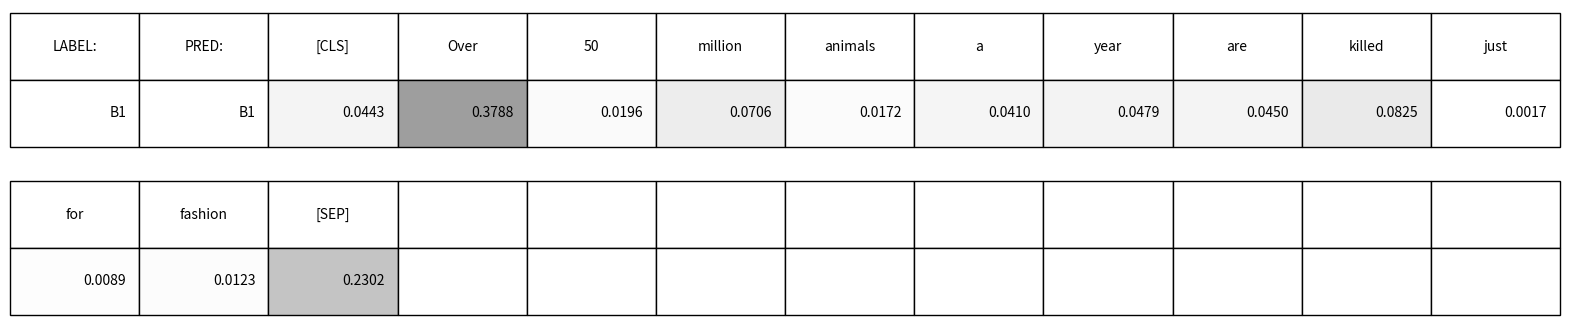

In [8]:
import matplotlib.font_manager as fm

fprop = fm.FontProperties(fname="resource/NotoSansJP-Regular.ttf")

i = 0
max_length = 12

tokens: list[str] = tokens_list[i]
attn = cls_attn[i].tolist()
label = EnglishCEFRDataset.target2level(labels[i].item())
prediction = EnglishCEFRDataset.target2level(predictions[i].item())

words = []
values = []
for t, a in zip(tokens, attn):
    if t == "[PAD]":
        break
    if t.startswith("##"):
        # combine subwords
        words[-1] = words[-1] + t[2:]
        values[-1] += a
    else:
        words.append(t)
        values.append(a)

words = ["LABEL:", "PRED:"] + words
attn_strs = [label, prediction] + [f"{a:.4f}" for a in values]
colors = ["w", "w"] + [str(1 - a) for a in values]


def plot_pairs(plt, words, values, colors, max_length=max_length):
    seq_length = len(words)
    if seq_length < max_length:
        words += [""] * (max_length - seq_length)
        values += [""] * (max_length - seq_length)
        colors += ["w"] * (max_length - seq_length)
    plt.axis("off")
    table = plt.table(cellText=[values], cellColours=[colors], colLabels=words, loc="center")
    for cell in table._cells:
        table._cells[cell].set_text_props(fontproperties=fprop)
    table.scale(1, 4)


num_lines = math.ceil(len(words) / max_length)
fig, ax = plt.subplots(num_lines, 1, figsize=(20, 2 * num_lines))
if num_lines == 1:
    plot_pairs(ax, words, attn_strs, colors)
else:
    for i in range(num_lines):
        s, e = i * max_length, (i + 1) * max_length
        plot_pairs(ax[i], words[s:e], attn_strs[s:e], colors[s:e])

plt.show()

In [6]:
line = "Replace me by any text you'd like."
line2 = "Some weights of the model checkpoint at bert-base-cased were not used"
inputs = tokenizer([line, line2], return_tensors="pt", padding="max_length").to(DEVICE)
print(inputs.keys())
print(inputs["attention_mask"] == 0)
print(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0]))
print(tokenizer.convert_ids_to_tokens(inputs["input_ids"][1]))

out = model(**inputs)
print(out.shape)

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True]], device='cuda:0')
['[CLS]', 'Rep', '##lace', 'me', 'by', 'any', 'text', 'you', "'", 'd', 'like', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '